In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils.fiber_dataset import import_fiber

# Fiber Modes

In [135]:
import numpy as np
from scipy.special import jv,yv
from scipy.optimize import fsolve

In [136]:
# Fiber Parameters

d = 105e-6    #  diameter of fiber core (m)
lam = 532e-9  # wavelength of laser used (m)
NA = 0.26     # fiber numerical aperture
nP = 224      # resolution of field in and out of fiber (pix)
L = 1.0       # fiber length (m)

# Assume core is glass and make necessary parameters based on inputs

ncore = 1.46                     #  refraction index core
nclad = np.sqrt(ncore**2-NA**2)  #  refraction index cladding
a = d/2                          #  radius
k = 2*np.pi/lam                 #  k-vector

In [137]:
# Generate normalised frequency axes

u = lambda b: a*np.sqrt(k**2 * ncore**2 - b**2)
w = lambda b: a*np.sqrt(b**2 - k**2 * nclad**2)
v = np.linspace(k*nclad,k*ncore,5000)

In [138]:
# Define radial coordinate system for inside and outside the core

Rin = np.linspace(0,1,100)[1:-1]
Rout = np.linspace(1,2,100)

In [139]:
# Establish gradient functions at core-cladding interface
# Remark: 
#   jv: Bessel function first kind
#   yv: Bessel function second kindq

Dcore = lambda b,l:  u(b)*jv(l+1,u(b))/jv(l,u(b))
Dclad = lambda b,l:  w(b)*yv(l+1,w(b))/yv(l,w(b))

In [150]:
# Preallocate memory by estimating number of modes and initialise indices
modeParams = np.zeros((int(0.5*(np.pi*a*NA/lam)**2),3))
ind = 1
l = 0
b = np.array([1,1])

In [162]:
# Loop over all values of radial index, l, for which Dcore can equal Dclad
while b.size != 0:
    
    # Define functions for smoothness across interface and search bounds
    findB = lambda b: np.real(Dcore(b,l)-Dclad(b,l))
    boundsFun = lambda b: jv(l,u(b))
    
    # Estimate search bounds with sign changes
    bounds = (np.sign(boundsFun(v)) != np.sign(np.roll(boundsFun(v),-1))).astype(np.float32)
    # bounds = [k*nclad,v(bounds),k*ncore]
    # bounds[bounds<k*(nclad+1e6*np.spacing(nclad))] = k*(nclad+1e6*np.spacing(nclad))
    # bounds[bounds>k*(ncore-1e6*np.spacing(ncore))] = k*(ncore-1e6*np.spacing(ncore))
    
    # Preallocate memory for all zeros of smoothness function at index l
    b = np.zeros(len(bounds))
    
    # Loop over all search bounds
    for i in range(1,len(bounds)-1):
        
        # Find search bounds by finding denominator function zeros
        if i != len(bounds):
            lbb = (bounds[i-1]+bounds[i])/2
            ubb = (bounds[i]+bounds[i+1])/2
            if np.sign(boundsFun(lbb)) != np.sign(boundsFun(ubb)):
                bounds[i] = np.fsolve(boundsFun,[lbb,ubb])
        
        
        # Edit search bounds by 0.5% to avoid asymptotes
        lb = bounds[i-1]+0.005*(bounds[i]-bounds[i-1])
        ub = bounds[i]-0.005*(bounds[i]-bounds[i-1])
        
        # Find smoothness function zeros
        if np.sign(findB(lb)) == np.sign(findB(ub)) or np.abs(ub-lb)<k*np.spacing(abs(ub-lb)) or np.isnan(findB(lb)) or np.isnan(findB(ub)):
            b[i-1] = np.nan
        else:
            b[i-1] = np.fsolve(findB,[lb,ub])
            
    b = b[:-2]
    b = b[np.logical_not(np.isnan(b))]
#     # Record mode indices with mode eigen values and update indices
#     ind = ind:(ind+length(b)-1);
#     modeParams[ind]=[l*np.ones((length(b),1)),(1:length(b))',b']
#     ind = np.max(ind)+1
#     l = l+1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [166]:
# Remove excess if memory was overestimated
# modeParams = modeParams[np.logical_not(np.isnan(np.sum(modeParams,-1)))]

In [ ]:
# Repeat modes with nonzero radial indices for odd and even functions
# D = np.sort([modeParams;modeParams(modeParams(:,1) != 0,:)],[2,1]);
# nModes = size(D,1);

In [ ]:
# Generate polar coordinates for Cartesian pixel grid
# [X,Y] = meshgrid(linspace(-1.02,1.02,nP));
# [T,R] = cart2pol(X,Y);
# mask = R<=1;

In [ ]:
# Preallocate memory for mode decompostion matrix and loop over all modes
# nModes=10
# modeMat = np.zeros((nP^2,nModes))
# for j in range(nModes):
    
#     # Draw each mode on Cartesian grid and vectorise for matrix
#     coreF = mask.*jv(D(j,1),u(D(j,3)).*R)./jv(D(j,1),u(D(j,3)));
#     cladF = (1-mask).*yv(D(j,1),w(D(j,3)).*R)./yv(D(j,1),w(D(j,3)));
#     cladF(isnan(cladF))=0;
#     lSign = 2*mod(j,2)-1;
#     modeF = exp(1i*D(j,1)*T*lSign).*(coreF+cladF);
#     modeMat(:,j) = reshape(modeF,nP^2,1)/norm(modeF(:));
    
#     # Plot (optional)
#     figure(2)
#     c2rgb(modeF)
#     axis square; axis off
#     drawnow
# end

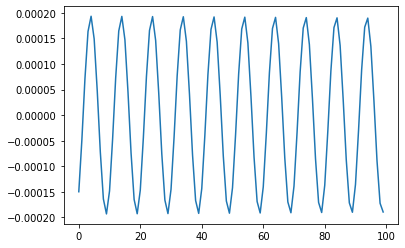

In [183]:
from scipy.special import jv,yv
plt.plot(yv(0,np.linspace(k*nclad,k*ncore,100)))

# Dataset

The loaded file hf is structured in two main folders:
 - Training 
 - Testing
 
And subfolders for each of the main folders:
 - Original_images
 - Speckle_images

For the Training folder, original and speckle images contain each:
 - 'MNIST'
 - 'Fashion-MNIST'
 - 'Random Patterns'

For the Testing folder, original and speckle images contain each:
 - 'MNIST'
 - 'Fashion-MNIST'
 - 'Muybridge Punch'

In [2]:
dataset_name = 'MNIST'
# dataset_name = 'Fashion-MNIST'
# dataset_name = 'Random Patterns'

train_loader,test_loader = import_fiber(dataset_name)

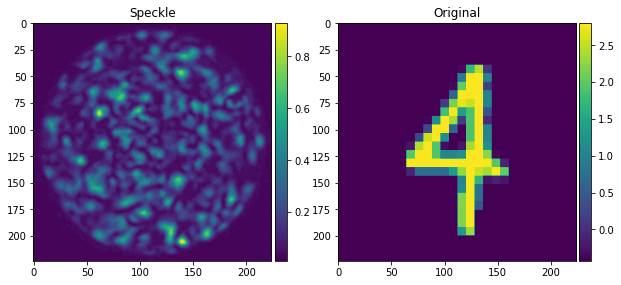

In [6]:
x,y = next(iter(train_loader))

N=0

fig,ax = plt.subplots(ncols=2,figsize=(10,10))

"""Speckles"""

imgs=[]

imgs.append(ax[0].imshow(y[N].permute(1,2,0).cpu()))
ax[0].set_title('Speckle')
imgs.append(ax[1].imshow(x[N].permute(1,2,0).cpu()))
ax[1].set_title('Original')

for i,img in enumerate(imgs):
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(img, cax=cax, orientation='vertical')

plt.show()

Idea: (like equivariant molecular DDPM)

- Random modes as seed of the DDPM. 
- Generate inverse of the TMs 
- Apply to the inverse of the TMs to the speckle pattern to obtain the image.

In [2]:
Idea: (use conditional variational diffusion autoencoder)

SyntaxError: invalid syntax (2711565885.py, line 1)

# Experiments DDPM

In [1]:
import os

#MLFlow
experiment_name='conditionalDDPM'; run_name=f'fiber_MNIST'

#Dataset
dataset=f'fiber_MNIST'; image_size=224

#Model
timesteps=4000; dim=64; n_layers=4; model_type='c'; clip = 1

#Hyperparameters
train_num_steps=2000; lr=0.00001; batch_size=8

os.system(f"python train.py --dataset={dataset} --experiment_name={experiment_name} --run_name={run_name} --image_size={image_size} --timesteps={timesteps} --dim={dim} --n_layers={n_layers} --model_type={model_type} --train_num_steps={train_num_steps} --lr={lr} --batch_size={batch_size} ")  

2022/07/18 12:43:15 WARNING mlflow.tracking.context.registry: Encountered unexpected error during resolving tags: 'getpwuid(): uid not found: 1001030000'
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | GaussianDiffusion | 29.8 M
--------------------------------------------
29.8 M    Trainable params
0         Non-trainable params
29.8 M    Total params
119.226   Total estimated model params size (MB)
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many

Epoch 1:  33%|███▎      | 500/1500 [02:33<05:06,  3.26it/s, loss=0.0287, v_num=eed0] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."



Testing: 100%|██████████| 1/1 [03:36<00:00, 216.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [03:36<00:00, 216.37s/it]


0

In [ ]:
Pensa a DDPM bijective --> se condizioni due modelli allo stesso tempo in entrambe le direzioni

# Experiments VAE + DDPM